Load and unpack the data

In [ ]:
!wget "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz"
!mkdir data
!mkdir data/flowers
!tar -xzvf "17flowers.tgz" -C "data/flowers"

--2024-08-22 11:08:39--  https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/17/17flowers.tgz [following]
--2024-08-22 11:08:40--  https://thor.robots.ox.ac.uk/flowers/17/17flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60270631 (57M) [application/octet-stream]
Saving to: ‘17flowers.tgz.2’

17flowers.tgz.2     100%[===================>]  57.48M  17.1MB/s    in 3.4s    

2024-08-22 11:08:44 (17.1 MB/s) - ‘17flowers.tgz.2’ saved [60270631/60270631]

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/flower

Import all libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision

from PIL import Image
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

Use GPU if available

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Define transformations

In [ ]:
number_of_images = 1360
image_h = 224
image_w = 224

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

auto_transforms = weights.transforms()

basic_transform = transforms.Compose([

    transforms.Resize((image_h, image_w)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Create tensor of labels

In [ ]:
possible_labels = torch.arange(0, 17)
labels = torch.repeat_interleave(possible_labels, 80).to(device)

Split to training, validation, and test sets

In [ ]:
all_ids = torch.arange(1, 1360)
train_ids, valid_ids, test_ids = random_split(all_ids, [0.7, 0.2, 0.1], generator=torch.Generator().manual_seed(1))

train_imgs = []
valid_imgs = []
test_imgs = []

train_labels = []
valid_labels = []
test_labels = []

for i in enumerate(train_ids):
  path = f"data/flowers/jpg/image_{str(i[1].item()).zfill(4)}.jpg"
  image = Image.open(path).convert("RGB")
  img = auto_transforms(image)
  train_imgs.append(img)
  train_labels.append(labels[i[1].item()])

train_imgs = torch.stack(train_imgs).to(device)
train_labels = torch.stack(train_labels).to(device)

for i in enumerate(valid_ids):
  path = f"data/flowers/jpg/image_{str(i[1].item()).zfill(4)}.jpg"
  image = Image.open(path).convert("RGB")
  img = basic_transform(image)
  valid_imgs.append(img)
  valid_labels.append(labels[i[1].item()])

valid_imgs = torch.stack(valid_imgs).to(device)
valid_labels = torch.stack(valid_labels).to(device)

for i in enumerate(test_ids):
  path = f"data/flowers/jpg/image_{str(i[1].item()).zfill(4)}.jpg"
  image = Image.open(path).convert("RGB")
  img = basic_transform(image)
  test_imgs.append(img)
  test_labels.append(labels[i[1].item()])

test_imgs = torch.stack(test_imgs).to(device)
test_labels = torch.stack(test_labels).to(device)

Plot an exemplary image

(torch.Size([952, 3, 224, 224]),
 tensor([[[ 0.4337,  0.4166,  0.5878,  ...,  0.9303,  1.0331,  1.3413],
          [ 0.5364,  0.3652,  0.5193,  ...,  1.0673,  1.4098,  1.7865],
          [ 0.9646,  0.5364,  0.4508,  ...,  1.0844,  1.4269,  1.6495],
          ...,
          [ 0.3652,  0.8276,  0.7591,  ..., -0.4397,  0.0227,  0.3652],
          [ 0.4508,  0.9474,  0.6221,  ..., -1.0219, -0.7822, -0.3369],
          [ 0.4166,  0.9646,  0.6734,  ..., -1.2788, -1.3130, -1.1247]],
 
         [[ 1.0280,  1.0980,  1.3256,  ...,  1.6408,  1.7283,  2.0434],
          [ 1.1506,  1.0455,  1.2731,  ...,  1.7633,  2.0609,  2.4111],
          [ 1.5882,  1.2206,  1.2031,  ...,  1.7108,  2.0084,  2.2185],
          ...,
          [ 0.9930,  1.4482,  1.4132,  ..., -0.3375,  0.0651,  0.3978],
          [ 1.1155,  1.5707,  1.2731,  ..., -0.8978, -0.7402, -0.3025],
          [ 1.1155,  1.5882,  1.3256,  ..., -1.0378, -1.1779, -1.0203]],
 
         [[-0.4275, -0.4101, -0.1487,  ...,  0.1651,  0.4439,  0.79

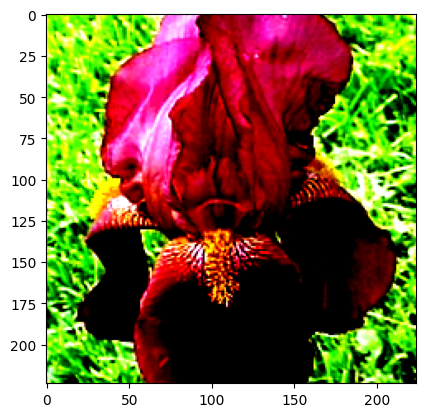

In [ ]:
import matplotlib.pyplot as plt

train_imgs.size(), train_imgs[0], plt.imshow(train_imgs[0].permute(1, 2, 0).cpu().numpy())

Create DataSets and DataLoaders

In [ ]:
batch_size = 32

train_ds = TensorDataset(train_imgs, train_labels)
valid_ds = TensorDataset(valid_imgs, valid_labels)
test_ds = TensorDataset(test_imgs, test_labels)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size, shuffle=False)

Define and train model

In [ ]:
def create_initial_model():
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  model = torchvision.models.efficientnet_b0(weights=weights).to(device)
  for param in model.features.parameters():
    param.requires_grad = False

  output_shape = len(labels)

  model.classifier = torch.nn.Sequential(
      torch.nn.Dropout(p=0.5, inplace=True),
      torch.nn.Linear(in_features=1280,
                      out_features=output_shape,
                      bias=True)).to(device)
  return model

In [ ]:
!pip install torchinfo
from torchinfo import summary

def model_summary(model):
  print(summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
  ))

In [ ]:
def train(model, num_epochs, train_dl, valid_dl, lr, step_size, gamma):
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


  loss_hist_train = [0] * num_epochs
  accu_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accu_hist_valid = [0] * num_epochs

  best_accu = 0
  trigger_times = 0
  patience = 10

  trained_for = num_epochs

  for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()*y_batch.size(0)
      is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
      accu_hist_train[epoch] += is_correct.sum()
    loss_hist_train[epoch] /= len(train_dl.dataset)
    accu_hist_train[epoch] /= len(train_dl.dataset)

    scheduler.step()

    model.eval()
    with torch.no_grad():
      for x_batch, y_batch in valid_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accu_hist_valid[epoch] += is_correct.sum()
    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accu_hist_valid[epoch] /= len(valid_dl.dataset)

    if accu_hist_valid[epoch] > best_accu:
      best_accu = accu_hist_valid[epoch]
      trigger_times = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
      trigger_times += 1
      if trigger_times > patience:
        print('Early stopping.')
        trained_for = epoch+1
        break

    if accu_hist_train[epoch] > 0.95:
      for param in model.features[-2:].parameters():  # Adjust the range to select layers
        param.requires_grad = True
      optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
    if accu_hist_train[epoch] > 0.98:
      for param in model.features[-4:].parameters():  # Adjust the range to select layers
        param.requires_grad = True
      optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00005)



    print(f'Epoch {epoch + 1}. t_loss = {loss_hist_train[epoch]:.4f}, t_accu = {accu_hist_train[epoch]:.4f}, v_accu {accu_hist_valid[epoch]:.4f} v_loss {loss_hist_valid[epoch]:.4f}')

  return loss_hist_train, loss_hist_valid, accu_hist_train, accu_hist_valid, trained_for


In [ ]:
model = create_initial_model()
num_epochs = 100
lr = 0.001
step_size = 15
gamma = 0.1
torch.manual_seed(42)
torch.cuda.manual_seed(42)
hist = train(model, num_epochs, train_dl, valid_dl, lr, step_size, gamma)

Epoch 1. t_loss = 4.5465, t_accu = 0.3508, v_accu 0.7463 v_loss 2.6158
Epoch 2. t_loss = 1.9979, t_accu = 0.7721, v_accu 0.8529 v_loss 1.5966
Epoch 3. t_loss = 1.2798, t_accu = 0.8687, v_accu 0.8824 v_loss 1.1754
Epoch 4. t_loss = 0.9266, t_accu = 0.8971, v_accu 0.8934 v_loss 0.9168
Epoch 5. t_loss = 0.7482, t_accu = 0.9118, v_accu 0.9007 v_loss 0.7897
Epoch 6. t_loss = 0.6323, t_accu = 0.9244, v_accu 0.9191 v_loss 0.7109
Epoch 7. t_loss = 0.5201, t_accu = 0.9443, v_accu 0.9191 v_loss 0.6436
Epoch 8. t_loss = 0.4748, t_accu = 0.9275, v_accu 0.9118 v_loss 0.6094
Epoch 9. t_loss = 0.4299, t_accu = 0.9443, v_accu 0.9118 v_loss 0.5817
Epoch 10. t_loss = 0.3884, t_accu = 0.9391, v_accu 0.9265 v_loss 0.5382
Epoch 11. t_loss = 0.3166, t_accu = 0.9611, v_accu 0.9265 v_loss 0.5246
Epoch 12. t_loss = 0.3130, t_accu = 0.9548, v_accu 0.9228 v_loss 0.4367
Epoch 13. t_loss = 0.2332, t_accu = 0.9569, v_accu 0.9412 v_loss 0.3793
Epoch 14. t_loss = 0.1903, t_accu = 0.9674, v_accu 0.9449 v_loss 0.3666
E

Evaluate the best model

In [ ]:
loaded_model = create_initial_model()
loaded_model.load_state_dict(torch.load('best_model.pth', map_location=device))

<All keys matched successfully>

In [ ]:
accuracy_test = 0
loaded_model.eval()
with torch.no_grad():
  for x_batch, y_batch in valid_dl:
    pred = loaded_model(x_batch)
    is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
    accuracy_test += is_correct.sum()
accuracy_test /= len(valid_dl.dataset)
print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.9669


In [ ]:
accuracy_test = 0
model.eval()
with torch.no_grad():
  for x_batch, y_batch in test_dl:
    pred = model_1(x_batch)
    is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
    accuracy_test += is_correct.sum()
accuracy_test /= len(test_dl.dataset)
print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.9481


Plot the accuracy and loss functions

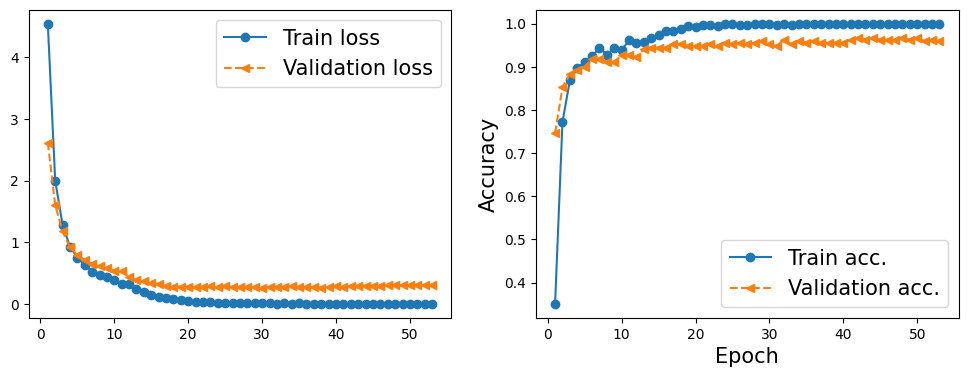

In [ ]:
x_arr = np.arange(hist[4]) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0][:hist[4]], '-o', label='Train loss')
ax.plot(x_arr, hist[1][:hist[4]], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, [v.cpu().numpy() for v in hist[2][:hist[4]]], '-o', label='Train acc.')
ax.plot(x_arr, [v.cpu().numpy() for v in hist[3][:hist[4]]], '--<',
label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()